# Surface temperature correction to AIRS data

Since the AIRS spectral trends appear to be mostly due to surface temperature trends, we want to try and apply a first order correction to remove the $\Delta TS$ signal from the calibrated irradiances. The Planck function in terms of wavelength is given by:

$$ B_{\lambda}(T) = \frac{2hc^2}{\lambda^5} \frac{1}{\exp{(hc/\lambda k_BT)}-1} d\lambda \quad Wm^{-2}{Sr}^{-1} $$

$$ B_{\nu}(T) = 2hc^2{\nu}^3 \frac{1}{\exp{(hc\nu/k_BT)}-1} d\nu \quad Wm^{-2}{Sr}^{-1} $$

We will start by assuming unitary surface emissivity and transmittance to the TOA such that the surface contribution to observed spectral irradiance (F) trends can be approximated as:

$$ \frac{dF}{dt} = \frac{\partial B_{\nu}(T)}{\partial T}\frac{dTS}{dt} $$

The partial derivative of the Planck function with respect to temperature is:

$$ \frac{dB_{\nu}(T)}{dT} =  \frac{2 h^2 c^3 {\nu}^4}{k_BT^2} \exp\left(\frac{hc\nu}{k_BT}\right) \frac{1}{\left[\exp(hc\nu/k_BT) - 1\right]^2} d\nu $$

Since the wavenumber in the above equations has units of $m^{-1}$, I will need to convert between $cm^{-1}$ before plugging into this expression. Intuitively, the wavenumber is the number of wavelengths in a unit length, so there will be 100x more when our unit length is 1m versus 1cm.

Wavenumber is defined in terms of wavelength following: $\nu = 1/100\lambda$, so we can transform the Planck function to be a function of wavenumber:  

$$ B_{\nu}(T) = 2hc^2 (10^{10} {\nu}^5) \frac{1}{\exp{(hc100\nu/k_BT)}-1} \frac{1}{100{\nu}^2}d\nu = 2\times 10^8 hc^2 {\nu}^3 \frac{1}{\exp{(hc100\nu/k_BT)}-1} d\nu \quad Wm^{-2}{Sr}^{-1}cm $$

I need to either multiple by a factor of $\pi$ or $4\pi$ to convert to irradiance.

We will start by assuming unitary surface emissivity and transmittance to the TOA such that the surface contribution to observed spectral irradiance (F) trends can be approximated as:

$$ \frac{dF}{dt} = \frac{\partial B_{\nu}(T)}{\partial T}\frac{dTS}{dt} $$

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.

from imports import (
    pd, np, xr, plt, sns, os, 
    glob, stats
    )

In [13]:
# Define constants globally
h = 6.626e-34 # [J*s] Planck constant
kB = 1.38e-23 # [J/K] Boltzmann constant
c = 299792458 # [m/s] speed of light

#### Define a simple Planck Curve to test equations

In [12]:
def Bv(T,nu):
    # nu is the wavenumber with units [1/m], T is temperature in [K]    
    return (2*h*c**2*nu**3) * 1/(np.exp(h*nu*c/(kB*T)) - 1) # W/m^2 per m-1 per Sr

Bv_vec = np.vectorize(Bv)

In [3]:
Ts = np.arange(200,301,1) # reasonable temperature range for the earth

# nus = np.linspace(500,2000,200)
nu_range = np.linspace(1,4000,2000) # Intended to be [cm-1]

(0.0, 2000.0)

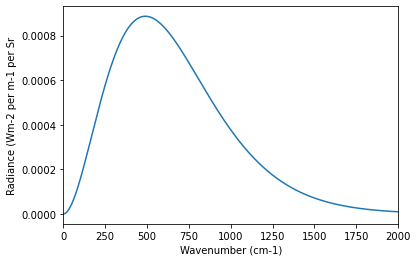

In [4]:
nu_range_m = nu_range * 100

Bv_test_250 = Bv_vec(250,nu_range_m)

plt.plot(nu_range,Bv_test_250)

plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Radiance (Wm-2 per m-1 per Sr')

plt.xlim(0,2000)

#### Test with Wien's Law

Following Wien's Law, the curve should be peak at $\nu_{max} = 5.879e10 T $. In wavenumber space ($\mathrm{cm^{-1}}$) this is $ 5.879e10 T / 100 c $.

In [6]:
# Calculate the max wavenumber from Wien's Law
T = 250

nu_max = 5.879e10*T / (100*c)
print(nu_max)

490.255828917484


In [7]:
# Calculate the max wavenumber from the calculated Planck curve
max_ind = np.where(Bv_test_250 == Bv_test_250.max())
print(nu_range[max_ind])

[489.12206103]


They match up well, indicating that I haven't made a mistake with the definition of the function.

#### Test with the Stefan-Boltzmann Law

The Stefan-Boltzmann Law states that the total irradiance should be proportional to the fourth power of the temperature: $ F = \sigma T^4 $, where $ \sigma = 5.67*10^{-8} \mathrm{Wm^{-2}T^{-4}} $.

In [8]:
# Calculate the predicted value from the Stefan-Boltzmann Law
sigma = 5.678e-8 # [Wm^-2K^-4]

Ptot = 250**4 * sigma
print(Ptot)

221.796875


In [9]:
# Integrate the Planck function
np.trapz(Bv_test_250,nu_range*100) # converts nus2 to meters before integration since the Planck function is in terms of meters

70.37506380838722

These values are off by a factor of $ \pi $ since I didn't integrate over solid angle.

In [10]:
# Integrate the Planck function
np.pi*np.trapz(Bv_test_250,nu_range*100) # converts nus2 to meters before integration since the Planck function is in terms of meters

221.08978345634225

Now the values are quite close, so the magnitude of my Planck function is also correct.

In [19]:
# Define a function to calculate the change in irradiance at a given wavenumber from the temperature change
# Function in latex/markdown
# $$ \frac{dB_{\nu}(T)}{dT} =  \frac{2 h^2 c^3 {\nu}^4}{k_BT^2} \exp\left(\frac{hc\nu}{k_BT}\right) \frac{1}{\left[\exp(hc\nu/k_BT) - 1\right]^2} d\nu $$

def dBvdT(T,nu,dnu):
        # T in temperature in [K], nu is the center wavenumber [1/m], and dnu is the width of the wavenumber band
    part1 = 2 * h**2 * c**3 * nu**4 / (kB * T**2) # first quotient
    
    part2 = np.exp(h * c * nu / (kB * T)) # exponential term
        
    part3 = 1 / (part2 - 1)**2

    # Convert to irradiance using pi and add spectral width of the bin
    return part1*part2*part3 * dnu * np.pi


dBvdT_vec = np.vectorize(dBvdT)

In [22]:
TTs,nnus = np.meshgrid(Ts,nu_range_m)

In [31]:
# The function takes wavenumber in units of m-1
out500 = dBvdT_vec(Ts,50000,1000)
out1000 = dBvdT_vec(Ts,100000,1000)
out2000 = dBvdT_vec(Ts,200000,1000)

In [35]:
outall = dBvdT_vec(TTs,nnus,1000)

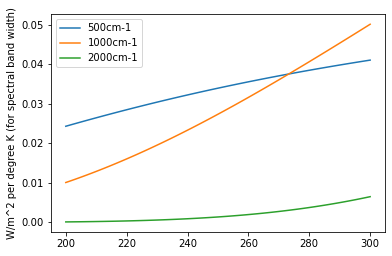

In [34]:
plt.plot(Ts,out500,label='500cm-1')
plt.plot(Ts,out1000,label='1000cm-1')
plt.plot(Ts,out2000,label='2000cm-1')

plt.ylabel('W/m^2 per degree K (for spectral band width)')
plt.legend()

While the concavity of these lines is different, they all demonstrate that at warmer temperatures, a unit change in temperature causes a greater increase in the emitted blackbody radiation. Because the blackbody curve is shifting to higher wavenumbers, the 500cm-1 curve has negative concavity, whereas 1000cm-1 and 2000cm-1 has positive concavity.

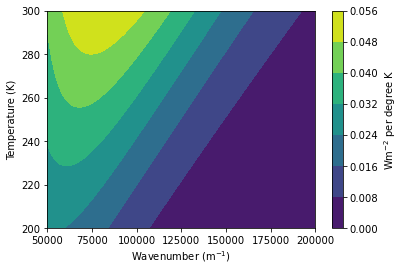

In [44]:
im = plt.contourf(nnus,TTs,outall)
plt.xlim(50000,200000)
plt.xticks(np.arange(50000,200001,25000))
plt.ylabel('Temperature (K)')
plt.xlabel('Wavenumber ($\mathrm{m^{-1}}$)')

plt.colorbar(im,label='$\mathrm{Wm^{-2}}$ per degree K')

Looking at a contour map, we can see that most of change is occuring where the Planck function is peaked. Note that the x units are in m-1 and I've supplied bin widths.

## Load pre-processed AIRS trends

### Spectral Irradiance Trends

In [45]:
airs_dir = '/glade/work/jonahshaw/obs/AIRS/'

all_data_spec_olr = xr.open_dataset('%s/%s/olr_spectral_trends_lonavg.nc' % (airs_dir,'arc_proc/'))

all_data_spec_olr_clr = xr.open_dataset('%s/%s/olr_clr_spectral_trends_lonavg.nc' % (airs_dir,'arc_proc/'))

### Surface skin temperature

#### Create function to average over the ascending and descending orbits

In [46]:
def average_AIRS_orbits(var,tseries_dir='/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0/tseries/'):
    
    ascending_file = glob.glob('%s/*%s_A.*.nc' % (tseries_dir,var))#[0]
    descending_file = glob.glob('%s/*%s_D.*.nc' % (tseries_dir,var))#[0]
                                
    if (len(ascending_file)!=1 or len(descending_file)!=1): # Handle string errors
        print('Unique ascending/descending file not found')
        return ascending_file,descending_file
    
#     print(ascending_file,descending_file)
    
    # Open timeseries files
    ds_A = xr.open_dataset(ascending_file[0])
    ds_D = xr.open_dataset(descending_file[0])
    
    # Rename removing orbit suffix
    ds_A = ds_A.rename({'%s_A' % var:var})
    ds_D = ds_D.rename({'%s_D' % var:var})
    
    # Add orbit dimension for concatenation.
    ds_A = ds_A[var].assign_coords({'orbit':0}).expand_dims('orbit')
    ds_D = ds_D[var].assign_coords({'orbit':1}).expand_dims('orbit')
    
    ds_both = xr.merge([ds_A,ds_D])
    ds_net = ds_both.mean(dim='orbit')[var]
    
    return ds_net
#     return ds_A,ds_D

#### New slower function that uses scipy.stats.linregress via apply_ufunc and gets info on statistical significance

In [47]:
def linregress2(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

In [48]:
def vectorized_linregress2(data):
    '''
    Package for vectorized linregress call from: 
    https://stackoverflow.com/questions/52094320/with-xarray-how-to-parallelize-1d-operations-on-a-multidimensional-dataset. 
    Not very general.
    '''
    
    regressed_month = xr.apply_ufunc(
        linregress2, data['year'], data,
        input_core_dims=[['year'], ['year']],
        output_core_dims=[["parameter"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=['float64'],
        output_sizes={"parameter": 5},
                      )
    
    return regressed_month

In [49]:
def compute_trends_n_signif2(subset_data):
    '''
    Package the trend calculating lines to save space. V2 uses vectorized_linregress2
    '''
    # create empty arrays for needed output
    _trends = xr.zeros_like(subset_data.groupby('time.month').mean('time')).load()
    _rvalues = _trends.copy()
    _pvalues = _trends.copy()

    # Potentially I should be able to format this to avoid this for loop too
    for i,_month in subset_data.groupby('time.month'):
#         print(i,end='')

        _yearlydata = _month.groupby('time.year').mean('time').chunk({'year': -1}) # let the other dimensions chunk however?
        regressed_month = vectorized_linregress2(_yearlydata)

        ii = i-1 # the count starts at month 1 (January) but we need to index starting at 0
        
        _trends[ii] = regressed_month.isel(parameter=0)
        _rvalues[ii] = regressed_month.isel(parameter=2)
        _pvalues[ii] = regressed_month.isel(parameter=3)

    # Calculate statistical significance
    N = len(_yearlydata.year)
    dof=N-2

    tcrit=stats.t.ppf(0.975,dof)  ## two-sided 95%
    t=_rvalues*np.sqrt(N-2)/np.sqrt((1-_rvalues*_rvalues))

    _statsig=(1-_pvalues)*100
    _notnull = t > tcrit # disproving the null hypothesis (slope is zero)    
    
    return _trends,_statsig,_notnull

In [50]:
AIRS_surf_skintemp = average_AIRS_orbits('SurfSkinTemp')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [51]:
skintemp_subset = AIRS_surf_skintemp.sel(time=slice('2003-01-01','2020-12-15'),lat=slice(None,59)).mean('lon')

skintemp_trends,skintemp_statsig,skintemp_notnull = compute_trends_n_signif2(skintemp_subset)

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [54]:
# Calculate the average skin temperature over the observation period so the linear Planck correction is most accurate
skintemp_monlat_avg = skintemp_subset.groupby('time.month').mean('time')

#### Calculate the sensitivity kernel (apply mean temperatures and AIRSL3 wavenumber range to the kernel function)

Set spectral bin variables

In [151]:
dnu_cm = 10 # [cm-1] band width
dnu_m = dnu_cm*1e2 # [m-1] band width

Set AIRS L3 wavenumber bin centers.

In [116]:
AIRSL3_nurange_cm = np.arange(15,1996,10)
AIRSL3_nurange_m = AIRSL3_nurange_cm * 1e2

In [117]:
# Expand dims so that the kernel can be calculated in a single step with a vectorized function call
AIRSL3_nurange_m_exp = np.expand_dims(AIRSL3_nurange_m,axis=[1,2])
skintemp_monlat_avg_exp = np.expand_dims(skintemp_monlat_avg,axis=0)

In [147]:
# Calculate the kernel and immediately read it into an xarray DataArray format
dnu_cm = 10 # [cm-1] band width
dnu_m = dnu_cm*1e2 # [m-1] band width

kernel_all = dBvdT_vec(skintemp_monlat_avg_exp,AIRSL3_nurange_m_exp,dnu_m)
# kernel_all = kernel_all.reshape(12,199,31) # this 

kernel_all_da = xr.DataArray(kernel_all,
#         dims=["month","wnum", "lat",],
        dims=["wnum","month", "lat",],
        coords=dict(
            wnum=(AIRSL3_nurange_cm),
            lat=(skintemp_monlat_avg['lat']),
            month=(skintemp_monlat_avg['month']),
        ),
        attrs=dict(
            description="OLR temperature kernel",
            units="Wm-2K-1",
        ),
    )

kernel_all_da = kernel_all_da.transpose("month", "wnum", "lat")

Test vectorized result against a single spectral band

In [153]:
nu_cm = 1005 # [cm-1] band center
nu_m = nu_cm*1e2 # [m-1] band center

kernel_1005 = dBvdT_vec(skintemp_monlat_avg,nu_m,dnu_m)

kernel_1005_da = xr.DataArray(kernel_1005,
        dims=["month", "lat",],
        coords=dict(
            lat=(skintemp_monlat_avg['lat']),
            month=(skintemp_monlat_avg['month']),
        ),
        attrs=dict(
            description="OLR temperature kernel",
            units="Wm-2K-1",
        ),
    )

<xarray.DataArray ()>
array(True)
Coordinates:
    wnum     int64 1005


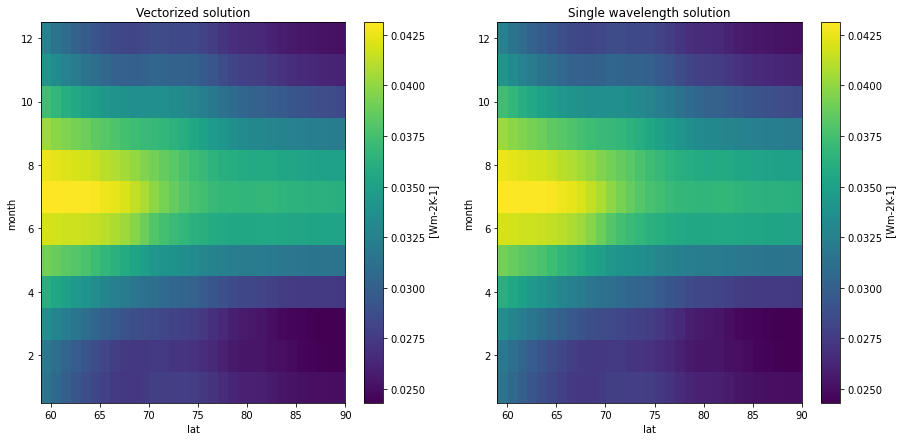

In [159]:
test_fig,test_axs = plt.subplots(1,2,figsize=(15,7))

kernel_all_da.sel(wnum=1005).plot(ax=test_axs[0])
test_axs[0].set_title('Vectorized solution')

kernel_1005_da.plot(ax=test_axs[1])
test_axs[1].set_title('Single wavelength solution')

print((kernel_all_da.sel(wnum=1005) == kernel_1005_da).all())

They are identical, so the vectorization was successful.

#### Compute trends predicted by the kernel

In [168]:
predicted_spectral_trends = skintemp_trends * kernel_all_da

### Compare trends predicted by the kernel with trends from AIRS observations

Text(0.5, 1.0, 'Trend at 1005 $ \\mathrm{cm^{-1}} $ predicted from surface temperature trend')

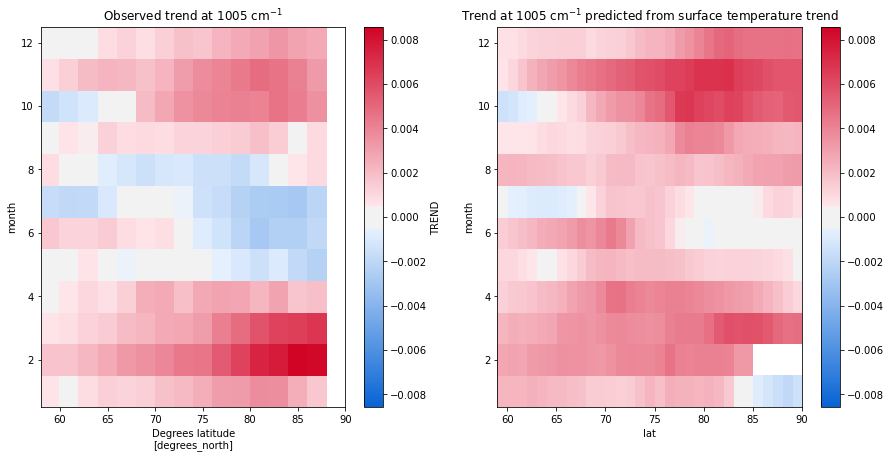

In [188]:
wnum = 1005
palette = sns.diverging_palette(257, 10, s=99, l=44, sep=15, n=8, as_cmap=True)
pallete = 'bwr'

eval_fig,eval_axs = plt.subplots(1,2,figsize=(15,7))

obs_data = all_data_spec_olr['TREND'].sel(wnum=wnum)
pred_data = predicted_spectral_trends.sel(wnum=wnum)

vmin = min(obs_data.min(),pred_data.min())
vmax = max(obs_data.max(),pred_data.max())
glob_max = max(np.abs(vmin),np.abs(vmax))

all_data_spec_olr['TREND'].sel(wnum=wnum).plot(ax=eval_axs[0],vmin=-glob_max,vmax=glob_max,cmap=palette)
eval_axs[0].set_title('Observed trend at %s $ \mathrm{cm^{-1}} $' % wnum)

predicted_spectral_trends.sel(wnum=wnum).plot(ax=eval_axs[1],vmin=-glob_max,vmax=glob_max,cmap=palette)
eval_axs[1].set_title('Trend at %s $ \mathrm{cm^{-1}} $ predicted from surface temperature trend' % wnum)


In [193]:
def compare_trends(obs,pred,wnum):
    
    palette = sns.diverging_palette(257, 10, s=99, l=44, sep=15, n=8, as_cmap=True)

    eval_fig,eval_axs = plt.subplots(1,2,figsize=(15,7))

    obs_data = obs.sel(wnum=wnum)
    pred_data = pred.sel(wnum=wnum)

    vmin = min(obs_data.min(),pred_data.min())
    vmax = max(obs_data.max(),pred_data.max())
    glob_max = max(np.abs(vmin),np.abs(vmax))

    all_data_spec_olr['TREND'].sel(wnum=wnum).plot(ax=eval_axs[0],vmin=-glob_max,vmax=glob_max,cmap=palette)
    eval_axs[0].set_title('Observed trend at %s $ \mathrm{cm^{-1}} $' % wnum)

    predicted_spectral_trends.sel(wnum=wnum).plot(ax=eval_axs[1],vmin=-glob_max,vmax=glob_max,cmap=palette)
    eval_axs[1].set_title('Trend at %s $ \mathrm{cm^{-1}} $ predicted from surface temperature trend' % wnum)
    
#     return eval_fig

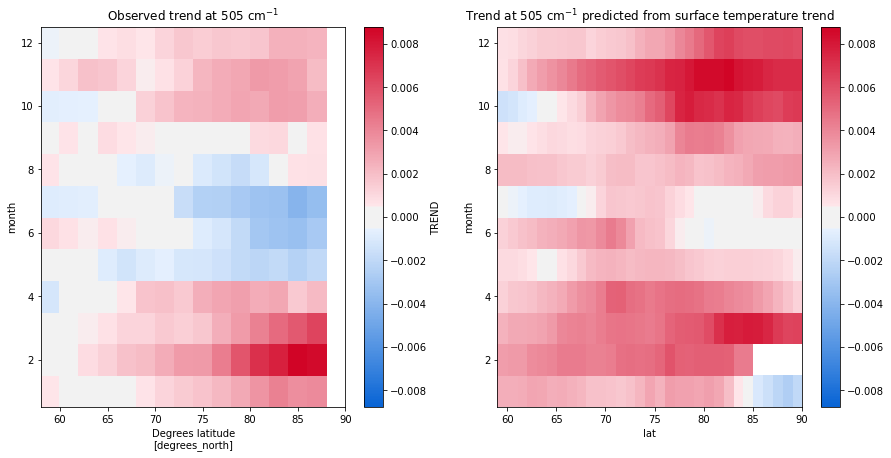

In [198]:
compare_trends(all_data_spec_olr['TREND'],predicted_spectral_trends,505)

In [ ]:
outall = dBvdT_vec(TTs,nnus,1000)

In [ ]:
dBvdT

#### Old stuff

The partial of the Planck function with respect to temperature is:

$$ B_{\nu}(T) = 2hc^2{\nu}^3 \frac{1}{\exp(hc\nu/k_BT)-1}d\nu $$

Newest:  

$$ \frac{dB_{\nu}(T)}{dT} =  \frac{2 h^2 c^3 {\nu}^4}{kT^2} \exp\left(\frac{hc\nu}{k_BT}\right) \frac{1}{\left[\exp(hc\nu/k_BT) - 1\right]^2} d\nu $$

Newer:

$$ \frac{dB_{\nu}(T)}{dT} =  2\times 10^{10} hc^{-2}{\nu}^4 d\nu \left(\frac{100hc\nu}{k_BT^2}\right) \exp\left(\frac{100hc\nu}{k_BT}\right) \frac{1}{\left[\exp(100hc\nu/k_BT) - 1\right]^2}  $$

Newer:

$$ \frac{dB_{\nu}(T)}{dT} =  \frac{2 h^2{\nu}^4}{c^2k_B T^2} \exp\left(\frac{h\nu}{k_BT}\right) \frac{1}{\left[\exp(h\nu/k_BT) - 1\right]^2} d\nu $$

Old:
$$ \frac{dB_{\nu}(T)}{dT} =  2\times 10^8 hc^2{\nu}^3 d\nu \left(\frac{100hc\nu}{k_BT^2}\right) \exp\left(\frac{100hc\nu}{k_BT}\right) \frac{1}{\left[\exp(100hc\nu/k_BT) - 1\right]^2}  $$

#### Code up and test against Wien's Law

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.

from imports import (
    pd, np, xr, plt, sns, os, 
    glob, stats
    )

In [8]:
def Blam(T,lam):
    # nu is the wavenumber with units [1/m]
    h = 6.62606957e-34 # [J*s] Planck constant
    kB = 1.3806488e-23 # [J/K] Boltzmann constant
    c = 299792458 # [m/s] speed of light
    
    return (2*h*c**2/lam**5) * 1/(np.exp((h*c/lam)/(kB*T)) - 1)

Blam_vec = np.vectorize(Blam)

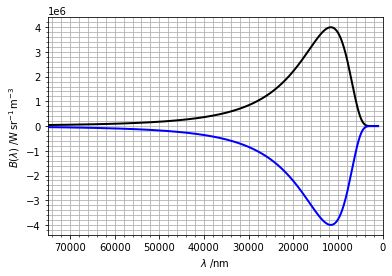

In [16]:
# Physical constants in SI units: Planck's constant (J.s),
# the speed of light (m.s-1), Boltzmann's constant (J.K-1)
h, c, kB = 6.62606957e-34, 299792458, 1.3806488e-23
# Sun temperature, K
# T = 5778
T = 250

lambda_min = 1000   # nm
lambda_max = 75000   # nm
n = 5000
wv = np.linspace(lambda_min, lambda_max, n)

# Planck curve as a function of wavelength in nm
B = 2 * h * c**2 / (wv*1.e-9)**5 / (np.exp(h * c / wv/1.e-9 / kB / T) - 1)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(wv, B, 'k', lw=2)
ax.plot(wv, -Blam_vec(T,wv*1e-9),'blue',lw=2) # great, my function works as well as this other one

ax.set_xlabel(r'$\lambda\;/\mathrm{nm}$')
ax.set_ylabel(r'$B(\lambda)\;/\mathrm{W\,sr^{−1}\,m^{−3}}$')

# Wavelength decreases from left to right: 4000 nm to 0:
ax.set_xlim(left=75000, right=0)
ax.minorticks_on()
ax.grid(which='both')

plt.show()


In [76]:
def Bv(T,nu):
    # nu is the wavenumber with units [1/m]
    h = 6.626e-34 # [J*s] Planck constant
    kB = 1.38e-23 # [J/K] Boltzmann constant
    c = 299792458 # [m/s] speed of light
    
    return (2*h*c**2*nu**3) * 1/(np.exp(h*nu*c/(kB*T)) - 1) # W/m^2 per m-1 per Sr

Bv_vec = np.vectorize(Bv)

In [80]:
def Bnu(T,nu):
    h = 6.626e-34 # Planck constant
    kB = 1.38e-23 # [J/K] Boltzmann constant
    c = 299792458 # [m/s] speed of light
    
#     part1 = 2e8**h*c**2*nu**3
    part1 = 2e-8**h*c**2*nu**3
    part2 = 1 / (np.exp(h*c*100*nu / (kB*T)) - 1)
    
    return part1*part2 # W/m^2 per cm-1

Bnu_vec = np.vectorize(Bnu)

In [50]:
sigma = 5.678e-8 # [Wm^-2K^-4]

In [51]:
Ptot = 250**4 * sigma
print(Ptot)

221.796875


In [73]:
Ts = np.arange(200,301,1)

# nus = np.linspace(500,2000,200)
nus2 = np.linspace(1,4000,2000) # Intended to be [cm-1]

Text(0, 0.5, 'Radiance (Wm-2 per m-1 per Sr')

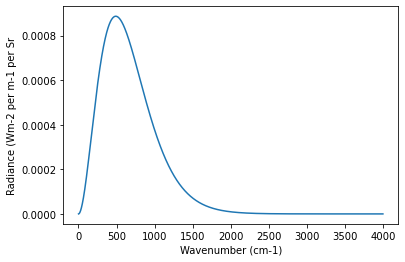

In [74]:
nus2_m = nus2 * 100

plt.plot(nus2,Bv_vec(250,nus2_m))

plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Radiance (Wm-2 per m-1 per Sr')

In [78]:
# The integration nearly matches the Stefan-Boltzmann law, great!
np.trapz(Bv_vec(250,nus2 * 100),nus2*100)*np.pi

221.08978345634225

Text(0, 0.5, 'Radiance (Wm-2 per cm-1 per Sr')

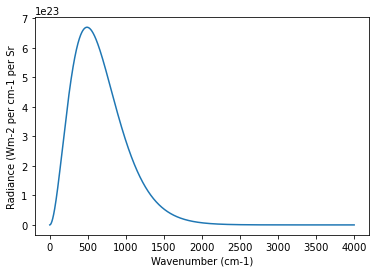

In [81]:
plt.plot(nus2,Bnu_vec(250,nus2))

plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Radiance (Wm-2 per cm-1 per Sr')

In [79]:
np.trapz(Bnu_vec(250,nus2),nus2)

5.3105239819187445e+26

In [29]:
out.max()

0.0008869315856247926

In [31]:
np.where(out == out.max())

(array([32]),)

In [32]:
nus2[32]

489.4472361809045

In [22]:
v_max = 5.879e10*250 # [Hz]
nu_max = v_max / c # [1/m]
nu_max_cm = nu_max / 100
print(v_max)
print(nu_max)
print(nu_max_cm)

14697500000000.0
49025.582891748396
490.25582891748394


This looks right. According to Wien's Law, the peak can be calculated from the temperature:

In [81]:
T = 250 # [K]

lambd = 2.9e-3 / T
print(lambd)

nu = 1/(100*lambd)
print(nu)

1.1599999999999999e-05
862.0689655172414


In [30]:
# Define a function to calculate the change in irradiance at a given wavenumber from the temperature change
def dBvdT(T,nu,dnu):
    h = 6.626e-34 # Planck constant
    kB = 1.38e-23 # [J/K] Boltzmann constant
    c = 299792458 # [m/s] speed of light
    
    part1 = 2 * 10**8 * h * c**2 * nu**3 * dnu
    
    part2 = 100*h*c*nu / (kB*T**2)
    
    part3 = np.exp(100*h*c*nu / (kB*T))
    
    part4 = 1 / (part3 - 1)**2

# Need to convert to irradiance using either pi or 4pi
    
    return part1*part2*part3*part4 # *np.pi


dBvdT_vec = np.vectorize(dBvdT)

Lets plot this function as a sanity test and to get some intuition on the processes at play.

In [60]:
TTs,nnus = np.meshgrid(Ts,nus)

In [56]:
out500 = dBvdT_vec(Ts,500,10)
out1000 = dBvdT_vec(Ts,1000,10)
out2000 = dBvdT_vec(Ts,2000,10)

In [61]:
outall = dBvdT_vec(TTs,nnus,10)

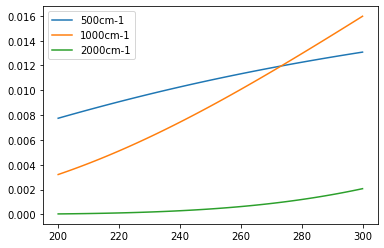

In [59]:
plt.plot(Ts,out500,label='500cm-1')
plt.plot(Ts,out1000,label='1000cm-1')
plt.plot(Ts,out2000,label='2000cm-1')

plt.legend()

While the concavity of these lines is different, they all demonstrate that at warmer temperatures, a unit change in temperature causes a greater increase in the emitted blackbody radiation.

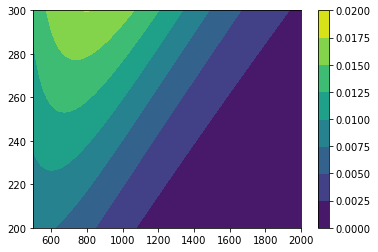

In [69]:
im = plt.contourf(nnus,TTs,outall)

plt.colorbar(im)

This contour plot shows the same thing, but also indicates that longer wavelengths (smaller wavenumbers are more sensitive to temperature changes in the temperature regime of the Arctic. I might guess that we're roughly looking at the peak of the Planck function at ~700cm-1. Since the Planck function both grows and shifts to shorter wavelengths at warmer temperatures, the peak should be on bluer side of the peak wavelength determined by Wien's law.

In [73]:
T = 280 # [K]

lambd = 2.9e-3 / T
print(lambd)

nu = 1/(100*lambd)
print(nu)

1.0357142857142856e-05
965.5172413793105


The peak is actually redder than the Wien's law peak, which I find confusing...

Lets load the AIRS data and see if my units are right/if this even remotely works.

## Load pre-processed AIRS trends

### Spectral Irradiance Trends

In [7]:
airs_dir = '/glade/work/jonahshaw/obs/AIRS/'

all_data_spec_olr = xr.open_dataset('%s/%s/olr_spectral_trends_lonavg.nc' % (airs_dir,'arc_proc/'))

all_data_spec_olr_clr = xr.open_dataset('%s/%s/olr_clr_spectral_trends_lonavg.nc' % (airs_dir,'arc_proc/'))

### Surface skin temperature

#### Create function to average over the ascending and descending orbits

In [17]:
def average_AIRS_orbits(var,tseries_dir='/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0/tseries/'):
    
    ascending_file = glob.glob('%s/*%s_A.*.nc' % (tseries_dir,var))#[0]
    descending_file = glob.glob('%s/*%s_D.*.nc' % (tseries_dir,var))#[0]
                                
    if (len(ascending_file)!=1 or len(descending_file)!=1): # Handle string errors
        print('Unique ascending/descending file not found')
        return ascending_file,descending_file
    
#     print(ascending_file,descending_file)
    
    # Open timeseries files
    ds_A = xr.open_dataset(ascending_file[0])
    ds_D = xr.open_dataset(descending_file[0])
    
    # Rename removing orbit suffix
    ds_A = ds_A.rename({'%s_A' % var:var})
    ds_D = ds_D.rename({'%s_D' % var:var})
    
    # Add orbit dimension for concatenation.
    ds_A = ds_A[var].assign_coords({'orbit':0}).expand_dims('orbit')
    ds_D = ds_D[var].assign_coords({'orbit':1}).expand_dims('orbit')
    
    ds_both = xr.merge([ds_A,ds_D])
    ds_net = ds_both.mean(dim='orbit')[var]
    
    return ds_net
#     return ds_A,ds_D

#### New slower function that uses scipy.stats.linregress via apply_ufunc and gets info on statistical significance

In [20]:
def linregress2(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

In [21]:
def vectorized_linregress2(data):
    '''
    Package for vectorized linregress call from: 
    https://stackoverflow.com/questions/52094320/with-xarray-how-to-parallelize-1d-operations-on-a-multidimensional-dataset. 
    Not very general.
    '''
    
    regressed_month = xr.apply_ufunc(
        linregress2, data['year'], data,
        input_core_dims=[['year'], ['year']],
        output_core_dims=[["parameter"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=['float64'],
        output_sizes={"parameter": 5},
                      )
    
    return regressed_month

In [22]:
def compute_trends_n_signif2(subset_data):
    '''
    Package the trend calculating lines to save space. V2 uses vectorized_linregress2
    '''
    # create empty arrays for needed output
    _trends = xr.zeros_like(subset_data.groupby('time.month').mean('time')).load()
    _rvalues = _trends.copy()
    _pvalues = _trends.copy()

    # Potentially I should be able to format this to avoid this for loop too
    for i,_month in subset_data.groupby('time.month'):
#         print(i,end='')

        _yearlydata = _month.groupby('time.year').mean('time').chunk({'year': -1}) # let the other dimensions chunk however?
        regressed_month = vectorized_linregress2(_yearlydata)

        ii = i-1 # the count starts at month 1 (January) but we need to index starting at 0
        
        _trends[ii] = regressed_month.isel(parameter=0)
        _rvalues[ii] = regressed_month.isel(parameter=2)
        _pvalues[ii] = regressed_month.isel(parameter=3)

    # Calculate statistical significance
    N = len(_yearlydata.year)
    dof=N-2

    tcrit=stats.t.ppf(0.975,dof)  ## two-sided 95%
    t=_rvalues*np.sqrt(N-2)/np.sqrt((1-_rvalues*_rvalues))

    _statsig=(1-_pvalues)*100
    _notnull = t > tcrit # disproving the null hypothesis (slope is zero)    
    
    return _trends,_statsig,_notnull

In [23]:
AIRS_surf_skintemp = average_AIRS_orbits('SurfSkinTemp')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [26]:
skintemp_subset = AIRS_surf_skintemp.sel(time=slice('2003-01-01','2020-12-15'),lat=slice(None,59)).mean('lon')

skintemp_trends,skintemp_statsig,skintemp_notnull = compute_trends_n_signif2(skintemp_subset)

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [36]:
# Calculate the average skin temperature over the observation period so the linear Planck correction is most accurate
skintemp_monlat_avg = skintemp_subset.groupby('time.month').mean('time')

#### Test at the 1005cm-1 spectral bin

In [40]:
test = dBvdT_vec(skintemp_monlat_avg,1005,10)

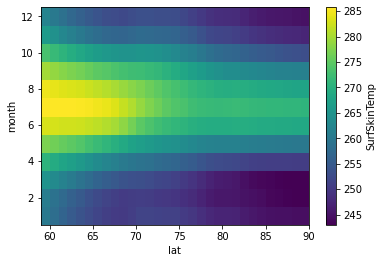

In [49]:
skintemp_monlat_avg.plot()

<AxesSubplot:>

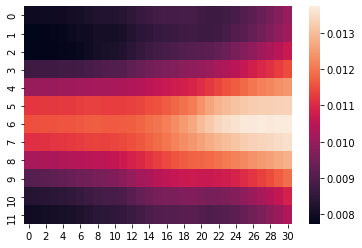

In [48]:
sns.heatmap(test)

The predicted irradiance change is the product of the surface temp trend and the kernel (partial of the planck distribution at the average temperature)

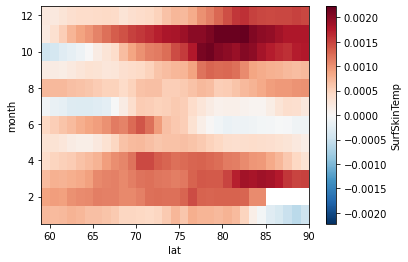

In [44]:
(skintemp_trends*test).plot()

In [12]:
ex1005 = all_data_spec_olr['TREND'].sel(wnum=1005)

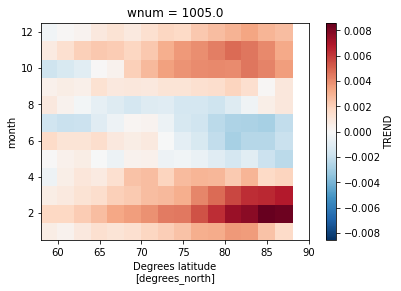

In [13]:
ex1005.plot()

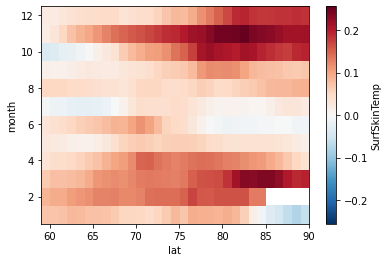

In [29]:
skintemp_trends.plot()